## 0. Introduction 

The aim of this lab is to get familiar with **Neural Networks**. We will be using some code extracts that were implemented on the week 4 Classification I lab and build a Neural Network. 

1.   This lab is part of Assignment 1 part 2.
2.   A report answering the <font color = 'red'>**questions in</font><font color = "maroon"> red**</font> should be submitted on QMplus along with the completed Notebook.
3. You should sibmit **a single report** for both this **AND** the week 4 notebooks.
3. The report should be a separate file in **pdf format** (so **NOT** *doc, docx, notebook* etc.), well identified with your name, student number, assignment number (for instance, Assignment 1), module code.
4. Make sure that **any figures or code** you comment on, are **included in the report**.
5. No other means of submission other than the appropriate QM+ link is acceptable at any time (so NO email attachments, etc.)
6. **PLAGIARISM** <ins>is an irreversible non-negotiable failure in the course</ins> (if in doubt of what constitutes plagiarism, ask!). 


For this lab, we will be using the [iris dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html#iris-dataset).

## 0.1 Intro to Neural Networks

As covered in the lecture notes, Neural Networks (NN) are inspired by biological brains. Each "neuron" does a very simple calculation, however collectively they can do powerful computations.

A simple model neuron is called a Perceptron and is comprised of three components:
1. The weights
2. The input function
3. The activation function

perceptron.png

We can re-imagine the logistic regression unit as a neuron (function) that multiplies the input by the parameters (weights) and squashes the resulting sum through the sigmoid.

A Feed Forward NN will be a connected set of logistic regression units, arranged in layers. Each unit’s output is a non-linear function (e.g., sigmoid, step function) of a linear combination of its inputs.
nn.svg

We will use the sigmoid as an activation function. Add the sigmoid function and `LogisticRegression` class from week 4 lab below.
Change the parameter initialization in `LogisticRegression`, so that a random set of initial weights is used.



<u><font color="maroon">**Q1.** Why is it important to use a random set of initial weights rather than initializing all weights as zero in a Neural Network? [2 marks] </font></u>


In [52]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from sklearn import model_selection
from sklearn import datasets
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from IPython import display

from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import accuracy_score as acc

import typing
%matplotlib inline

torch.manual_seed(0)

In [5]:
def sigmoid(z: torch.Tensor) -> torch.Tensor:
    z = 1/(1+torch.exp(-z))
    return z

In [6]:
class LogisticRegression(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.weight = nn.Parameter(torch.zeros(1, num_features), requires_grad=False)
        nn.init.xavier_normal_(self.weight)

    def forward(self, x):
        y = 0
        self.z = x@self.weight.T
        y = sigmoid(self.z)
        return y

# 1. The XOR problem

Let's revisit the XOR problem.

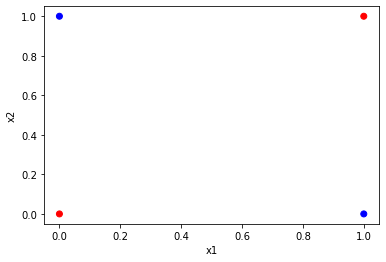

In [7]:
x1 = [0, 0, 1, 1]
x2 = [0, 1, 0, 1]
y = [0, 1, 1, 0]

c_map = ['r', 'b', 'b', 'r']
plt.scatter(x1, x2, c=c_map)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

<u><font color="maroon"> **Q2.** How does a NN solve the XOR problem? [1 marks]</font></u>


We will implement back-propagation on a Feed Forward network to solve the XOR problem. The nework will have 2 inputs, 2 hidden neurons and one output neuron. The architecture is visualised as follows:

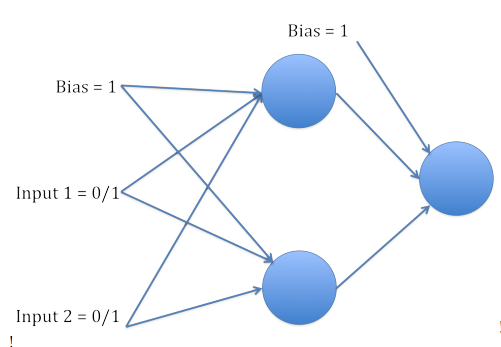

Using `LogisticRegression` and `sigmoid` from week 4 lab, implement the forward pass in the class below. Assume a single sample at a time (i.e. the shape of `x` is `(1, num_features`)). [2 marks]

Hint: Check `ModuleList` [documentation](https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html).

In [8]:
class NeuralNetwork(nn.Module):
    def __init__(self, num_inputs, num_neurons, num_outputs):
        super().__init__()
        self.hidden_layer = nn.ModuleList([LogisticRegression(num_inputs) for i in range(num_neurons)])
        self.output_layer = nn.ModuleList([LogisticRegression(num_neurons+1) for i in range(num_outputs)]) # +1 for the bias

    def forward(self, x: torch.tensor) -> torch.tensor:
        z_hidden = torch.ones(len(self.hidden_layer))
        y_hidden = torch.ones(len(self.hidden_layer) + 1) # +1 for the bias
        z_output = torch.ones(len(self.output_layer))
        
        for i,h in enumerate(self.hidden_layer):
            y_hidden[i] = h(x)
            z_hidden[i] = h.z
        for j,o in enumerate(self.output_layer):
            y = o(y_hidden)
            z_output[j] = o.z
            
        self.y_hidden = y_hidden
        self.z_hidden = z_hidden
        self.z_output = z_output
        
        return y

    def backward_pass(self, x: torch.tensor, y: torch.tensor, lr: float) -> None:
        
        ## Initializating the necessary variables
        out_weights = torch.Tensor(list(self.output_layer.parameters())[0])
        hid_weights = torch.stack(list(self.hidden_layer.parameters())).squeeze(dim=1)
        y_pred = self(x)
        
        ## Chain Rule for del of cost w.r.t. del of output weights
        del_chain = y_pred - y
        del_chain = del_chain*(sigmoid(self.z_output)*(1-sigmoid(self.z_output)))
        del_w_output = del_chain.reshape(-1,1)@self.y_hidden.reshape(1,-1)
        
        ## Extending the chain Rule for del of cost w.r.t. del of hidden weights
        del_chain = torch.sum(del_chain*out_weights, dim=-1)
        del_chain = del_chain*(sigmoid(self.z_hidden)*(1-sigmoid(self.z_hidden)))
        del_w_hidden = del_chain.reshape(-1,1)@x.reshape(1,-1)
        
        ## Updating the Output parameters
        out_weights = out_weights - (lr*del_w_output)
        
        ## Updating the Hidden parameters
        hid_weights = hid_weights - (lr*del_w_hidden)
        
        for p,u in zip(self.hidden_layer.parameters(), hid_weights):
            p.copy_(u)
        for p,u in zip(self.output_layer.parameters(), out_weights):
            p.copy_(u)
            
        return

In [9]:
# test it works!!
x_test = torch.tensor([0., 0., 1.]) # last value is the bias
y_test = torch.tensor([0.])
model = NeuralNetwork(num_inputs=3, num_neurons=2, num_outputs=1)
print(model(x_test))
print(model)
for name, param in model.named_parameters():
    print(name, param)

print('\nHidden layer weight matrix:')
print(torch.stack(list(model.hidden_layer.parameters())))

tensor([0.4261])
NeuralNetwork(
  (hidden_layer): ModuleList(
    (0): LogisticRegression()
    (1): LogisticRegression()
  )
  (output_layer): ModuleList(
    (0): LogisticRegression()
  )
)
hidden_layer.0.weight Parameter containing:
tensor([[ 1.0896, -0.2075, -1.5406]])
hidden_layer.1.weight Parameter containing:
tensor([[ 0.4019, -0.7669, -0.9890]])
output_layer.0.weight Parameter containing:
tensor([[ 0.2852,  0.5926, -0.5086]])

Hidden layer weight matrix:
tensor([[[ 1.0896, -0.2075, -1.5406]],

        [[ 0.4019, -0.7669, -0.9890]]])


In [10]:
model.hidden_layer

ModuleList(
  (0): LogisticRegression()
  (1): LogisticRegression()
)

In the `NeuralNetwork` class above, fill in the `backward_pass()` method. 

The implementation should support outputs of any size. To implement the backward pass, follow the steps below:



*   **Step 1:** For each output, $k$, calculate the partial derivative: $\delta_{k} = (y_{k}-t_{k}) \times g'(x_{k})$ \\
where $y_{k}$ is the response of the output neuron and $t_{k}$ is the desired output (target). The derivative of the sigmoid function $g'(x_{k})$ is defined as $g'(x_{k}) = g(x_{k}) × (1 - g(x_{k}))$ [1 marks]
*  **Step 2:** We now need to probagate this error to the hidden neurons. To accomplish this remember that: $$
 \delta_{j} = g^\prime(x_{j}) \sum_{k} w_{jk} \delta_{k}
$$  where $\delta_{j}$ is the error on the j-th hidden neuron,$x_{j}$ is the value of the hidden neuron (before it has been passed through the sigmoid function), $g^\prime$ is the derivative of the sigmoid function, $\delta_{k}$ is the error from the output neuron calculated in step 1, and $w_{jk}$ is the weight from the hidden neuron $j$ to the output neuron $k$. [1 marks]

* **Step 3:** We now need to update the output weights, i.e. the connections from the hidden neurons to the output neurons. This is accomplished using the formula: $$
 w_{jk} = w_{jk} - \eta \delta_{k} \alpha_{j}
$$ where $w_{jk}$ is the weight connecting the j-th hidden neuron to the k-th output neuron. $a_{j}$ is the activity of the j-th hidden neuron (after it has been transformed by the sigmoid function), $\delta_{k}$ is the error from the output neuron stored in output\_deltas and $\eta$ is the learning rate [1 mark]

* **Step 4:**  Finally we need to update the hidden weights, i.e. the connections from the hidden neurons to the inputs. Here, again we use this equation $$
 w_{ij} = w_{ij} - \eta \delta_{j} x_{i}
$$ where $w_{ij}$ is the weight connecting the i-th input to the j-th hidden neuron. $x_{i}$ is the i-th input, $\delta_{j}$ is the backpropagated error (i.e., hidden deltas) from the j-th hidden neuron and $\eta$ is the learning rate. [1 mark]



In [11]:
# test it works
model.backward_pass(x_test, y_test, 1)

In [12]:
def bce(y_true: torch.Tensor, y_pred: torch.Tensor) -> torch.Tensor:
    cost = torch.mean((-y_true*torch.log(y_pred)) - (1-y_true)*torch.log(1-y_pred))
    return cost

Now modify the code below to train a model on the XOR problem. Make sure to use an appropriate lr and number of iterations. Use the BCE method from week 4 to visualize cost. [1 mark]

torch.Size([4, 3])


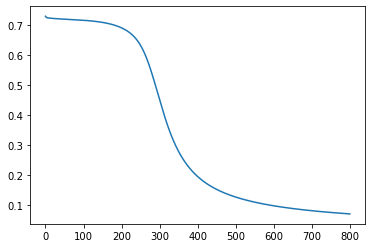

tensor([0., 1., 1., 0.]) tensor([0.0767, 0.9348, 0.9337, 0.0000])


In [23]:
x1 = torch.tensor([0., 0., 1., 1.])
x2 = torch.tensor([0., 1., 0., 1.])
bias = torch.ones_like(x1)
x = torch.stack([x1, x2, bias]).permute(1, 0)
print(x.shape)
y = torch.tensor([0., 1., 1., 0.])

lr = 0.415
iterations = 1200
model = NeuralNetwork(num_inputs=3, num_neurons=2, num_outputs=1)

errors = list()
for ep in range(iterations):
    error = 0
    for i in range(x.shape[0]):
        y_pred = model(x[i])
        error += bce(y[i], y_pred)
        model.backward_pass(x[i], y[i], lr)
    errors.append(error/x.shape[0])
plt.plot(list(range(iterations)), errors)
plt.show()

y_pred = torch.zeros_like(y)
for i in range(x.shape[1]):
    y_pred[i] = model(x[i])
print(y, y_pred)

# 2. Iris Dataset
We will now use pytorch built-in methods to create an MLP classifier for the iris dataset.

In [14]:
iris = datasets.load_iris()
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

Split the data to train and test sets (make sure the same random seed is used as previously) and normalize using the method from week 4. We will use all attributes in this lab. [2 marks]

In [44]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    iris.data,
    iris.target,
    test_size=0.2,
    random_state=42
    )
x_train = torch.from_numpy(X_train).float()
x_test = torch.from_numpy(X_test).float()

y_train = torch.from_numpy(y_train).float()
y_train = y_train.reshape(-1, 1)

y_test = torch.from_numpy(y_test).float()
y_test = y_test.reshape(-1, 1)

In [45]:
def norm_set(x: torch.Tensor, mu: torch.Tensor, sigma: torch.Tensor) -> torch.tensor:
    normalized_tensor = (x - mu)/sigma
    return normalized_tensor

mu_x_train = x_train.mean(axis=0).unsqueeze(dim=0)
std_x_train = x_train.std(axis=0).unsqueeze(dim=0)

x_train = norm_set(x_train, mu_x_train, std_x_train)
x_test = norm_set(x_test, mu_x_train, std_x_train)

y_train = F.one_hot(y_train.reshape(-1).long(), num_classes=3)
y_test = F.one_hot(y_test.reshape(-1).long(), num_classes=3)

In [46]:
y_train = y_train.float()
y_test = y_test.float()

Using pytorch built in methods (and using the training loop from week 4 as guideline for the train loop), build an MLP with one hidden layer. Train the network multiple times for the following number of hidden neurons `{1, 2, 4, 8, 16, 32}`. 

<u><font color="maroon"> **Q3.** Explain the performance of the different networks on the training and test sets. How does it compare to the logistic regression example? Make sure that the data you are refering to is clearly presented and appropriately labeled in the report. [8 marks]</font></u>

In [47]:
versicolor_labels = y_train[:, 1].reshape(-1, 1).float()
versicolor_testy = y_test[:, 1].reshape(-1, 1).float()

In [48]:
print(versicolor_labels.reshape(-1))
print(versicolor_testy.reshape(-1))

tensor([0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
        1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1.,
        1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1.,
        1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
        1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0.])
tensor([1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


In [49]:
def train(model, x, y, test_x, test_y, optimiser,epochs, alpha, ):
    train_lst = list()
    test_lst = list()
    for i in range(epochs):
        model.train()
        optimiser.zero_grad()
        pred = model(x)
        cost = F.binary_cross_entropy(pred, y, reduction='mean')
        cost.backward()
        train_lst.append(cost.item())
        optimiser.step()
        model.eval()
        with torch.no_grad():
            test_pred = model(test_x)
            test_cost = F.binary_cross_entropy(test_pred, test_y, reduction='mean')
            test_lst.append(test_cost)
    fig, axs = plt.subplots(2)
    axs[0].plot(list(range(i+1)), train_lst)
    axs[1].plot(list(range(i+1)), test_lst)
    plt.show()
    print('Minimum train cost: {}'.format(min(train_lst)))
    print('Minimum test cost: {}'.format(min(test_lst)))
    print("--------------------------------------------------------------------------\n")

In [50]:
def make_logistic_regression_model(num_hidden_neurons):
    model = nn.Sequential(nn.Linear(x_train.shape[1], num_hidden_neurons), 
                          nn.ReLU(),
                          nn.Linear(num_hidden_neurons, 1),
                          nn.Sigmoid())
    return model

----------------- 1 Hidden Neurons--------------------


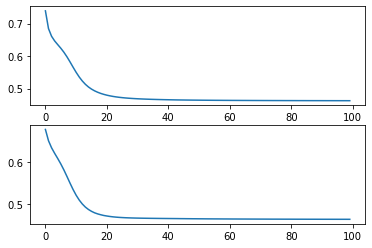

Minimum train cost: 0.4628077745437622
Minimum test cost: 0.4646872580051422
--------------------------------------------------------------------------

[[10 11]
 [ 0  9]]
The Training accuracy of the model: 67.50%
The Test accuracy of the model: 63.33%

----------------- 2 Hidden Neurons--------------------


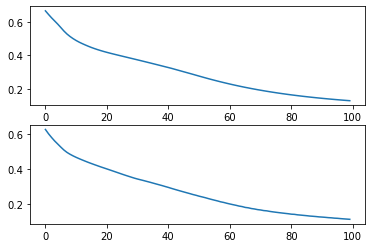

Minimum train cost: 0.12838751077651978
Minimum test cost: 0.11372236907482147
--------------------------------------------------------------------------

[[21  0]
 [ 0  9]]
The Training accuracy of the model: 97.50%
The Test accuracy of the model: 100.00%

----------------- 4 Hidden Neurons--------------------


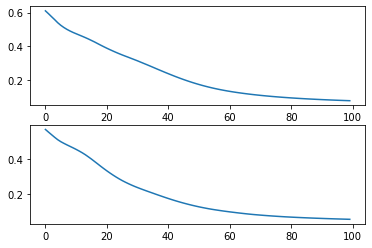

Minimum train cost: 0.07867659628391266
Minimum test cost: 0.060316912829875946
--------------------------------------------------------------------------

[[21  0]
 [ 1  8]]
The Training accuracy of the model: 95.83%
The Test accuracy of the model: 96.67%

----------------- 8 Hidden Neurons--------------------


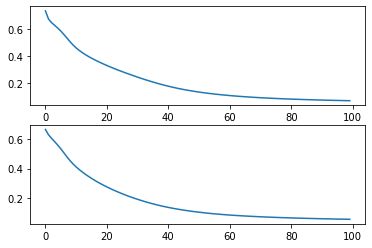

Minimum train cost: 0.07212495058774948
Minimum test cost: 0.053867537528276443
--------------------------------------------------------------------------

[[21  0]
 [ 0  9]]
The Training accuracy of the model: 95.83%
The Test accuracy of the model: 100.00%

----------------- 16 Hidden Neurons--------------------


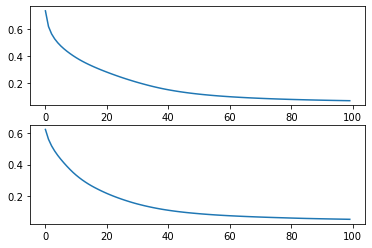

Minimum train cost: 0.06999407708644867
Minimum test cost: 0.05282251164317131
--------------------------------------------------------------------------

[[21  0]
 [ 0  9]]
The Training accuracy of the model: 96.67%
The Test accuracy of the model: 100.00%

----------------- 32 Hidden Neurons--------------------


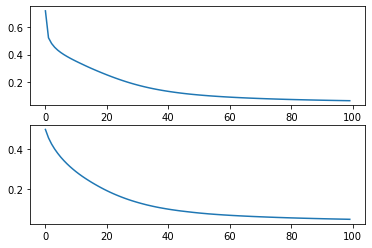

Minimum train cost: 0.06710771471261978
Minimum test cost: 0.04884183406829834
--------------------------------------------------------------------------

[[21  0]
 [ 0  9]]
The Training accuracy of the model: 98.33%
The Test accuracy of the model: 100.00%



In [53]:
alpha = 0.8
epochs = 100
db = 0.5 ## decision boundary

# num_hidden_neurons = 4

for n_h_neurons in [1, 2, 4, 8, 16, 32]:
    print(f"----------------- {n_h_neurons} Hidden Neurons--------------------")
    
    model = make_logistic_regression_model(n_h_neurons)
    optimiser = optim.SGD(model.parameters(), alpha)

    train(model, x_train, versicolor_labels, x_test, versicolor_testy, optimiser, epochs, alpha)
    y_pred_test = (model(x_test) > db).float()
    y_pred_train = (model(x_train).detach() > db).int().numpy()
    
    print(cm(versicolor_testy, y_pred_test))
    
    print(f"The Training accuracy of the model: {acc(versicolor_labels.numpy(), y_pred_train)*100:.2f}%")
    print(f"The Test accuracy of the model: {acc(versicolor_testy, y_pred_test)*100:.2f}%")
    print()

---